# Historic Bitcoin Price Data Prediction

Extensive research was carried out on historic Bitcoin price prediction via Multiple Linear Regression. Originally, MLR was used as a "reference model" to develop a framework/pipeline, where one can easily switch between different ML models and metrics to perform Bitcoin network feature selection with the Nondominated Sorting Genetic Algorithm II. However, since the results were suprisingly good, further research was conducted on this topic.

## NSGA-II - A Multiobjective Evolutionary Algorithm

Nondominated Sorting Genetic Algorithm II is an elitist, multiobjective evolutionary algorithm which overcomes the common problems of nondominated sorting evolutionary algorithms: computational complexity, nonelitist approach, reliance on the concept of sharing, thus requiring an extra parameter. Since we try to extract meaningful features from the Bitcoin network to predict the said cryptocurrency's price as accurately as possible, it is crucial to design our feature selection process to minimize the number of features while maximizing the predictive power of our model. Minimizing the feature set is necessary to reduce the variance of our model, thus reducing the probability of overfitting while the need to maximize predictive power is self-explanatory. It is clear that we need to solve a multi-objective optimization problem. As it was shown by Siedlecki and Sklansky that genetic algorithms are successful at large scale feature selection and due to the nature of our optimization problem, NSGA-II can be considered as a good candidate for the problem.

## Multiple Linear Regression

As mentioned above, the model was originally chosen to serve as a reference for developing a highly configurable pipline for Bitcoin feature selection and price prediction. We opted to use Ordianry Least Squares as an estimator for the model. The reason of choice was simplicity. Regarding the model's usefuleness for price prediction, one would think that it is highly unlikely that it will successfully predict price movements since the model presumes linear relationships between the features of the Bitcoin network and the prices of bitcoin, while it also assumes that the input features are independent. Despite all this, the results were better than expected.

## Features

'market-cap', 
'transaction-fees-usd', 
'n-transactions', 
'n-unique-addresses', 
'n-transactions-per-block',
'n-orphaned-blocks',
'output-volume',
'estimated-transaction-volume-usd',
'trade-volume',
'tx-trade-ratio',
'cost-per-transaction',
'hash-rate',
'difficulty',
'miners-revenue',
'median-confirmation-time',
'bitcoin-days-destroyed',
'avg-block-size'

## Data Splitting

## Metrics

**R<sup>2</sup> - Goodnes-of-Fit**

R<sup>2</sup> (or Coefficient of Determination) is a commonly used metric when evaluating regression models which indicates how well the regression line approximates the given data. Its value is in the range of [0,1], where 1 indicates a perfect fit. One problem with R<sup>2</sup> is that it does not filter out irrelevant features. One can add new, meaningless variables to the model while increasing its R<sup>2</sup> score. Also this metric could potentially over-, under-predict the data, thus other metrics should be used in conjuction.
It is calculated as follows:

**Root-Mean-Square Error**

RMSE is a good metric for numerical predictions which indicates the sample standard deviation between the observed and predicted data. It is usually a preferable metric over both the Mean Absolute Error and the Mean-Square error because RMSE penalizes larger errors more than the MAE, which is crucial to good price prediction, while it is easier to interpret than the MSE due to having the same dimensions as the predicted values (y).
It is calculated as follows:

## Results

Due to the nature of EAs, one cannot be sure that the extracted features are the most meaningful ones, thus resulting in the best prediction. Hence, it is a good idea to run the EA several times and use some intuition to improve the quality of the feature set. Some of the features that regularly came up, were 'market-cap', either 'n-transactions'/ 'n-unique-addresses'/'n-transactions-per-block', 'trade-volume', 'output-volume', 'tx-trade-ratio', 'cost-per-transaction', 'miners-revenue', 'bitcoin-days-destroyed' and 'avg-block-size'. If we observe the pairplots of these variables compared to the market price of Bitcoin in USD, which we would like to predict, one can immediately see that 'market-cap', 'cost-per-transaction' and 'miners-revenue' are highly collinear with the price of Bitcoin. Also, when running the algorithm with large populations through high number of iterations, these were the selected features in general, in addition to 'n-unique-addresses'. After some further experimenting, our final feature set is as follows: 
'market-cap', 'n-unique-addresses', 'trade-volume', 'output-volume', 'cost-per-transaction', 'miners-revenue', 'bitcoin-days-destroyed'. This results in an RMSE of 15.63 and R<sup>2</sup> of 0.96. Considering that the price of Bitcoin during this period was between ~$225 and ~$470, an RMSE of 15.63, with units in dollars, can be considered fairly good. After visualizing the actual and predicted prices, we can see that our model usually overestimates the price of Bitcoin but captures the price changes quite accurately. This could be potentially leveraged when devising a trading strategy based on our model predictions. 

# References

*http://www.sciencedirect.com/science/article/pii/0167865589900378
*http://sci2s.ugr.es/sites/default/files/files/Teaching/OtherPostGraduateCourses/MasterEstructuras/bibliografia/Deb_NSGAII.pdf

In [10]:
%matplotlib inline

from deap import base, creator, tools, algorithms
from IPython.display import display
from ipywidgets import widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn import preprocessing as preproc, datasets, linear_model
from sklearn.metrics import mean_squared_error as mse, accuracy_score as acc_scr

toolb = base.Toolbox()
pd.set_option('html', False)
np.set_printoptions(threshold=np.nan)
sns.set()

# Data Preprocessing

In [2]:
# Note: chart names could occasionally change on blockchain.info
URL = 'https://blockchain.info/charts/%s?timespan=all&format=csv'
CHARTS = ['market-price',
          'market-cap', 
          'transaction-fees-usd', 
          'n-transactions', 
          'n-unique-addresses', 
          'n-transactions-per-block',
          'n-orphaned-blocks',
          'output-volume',
          'estimated-transaction-volume-usd',
          'trade-volume',
          'tx-trade-ratio',
          'cost-per-transaction',
          'hash-rate',
          'difficulty',
          'miners-revenue',
          'median-confirmation-time',
          'bitcoin-days-destroyed',
          'avg-block-size'
         ]

FRAMES = []   # contains everything as DataFrames from charts
FEATURES = [] # standardized DataFrames from charts, excluding market-price

date_parse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y %H:%M:%S')

def prep_data(date_from, date_to):
    del FRAMES[:]
    del FEATURES[:]
    
    # Create DataFrame from the market-price
    data = pd.read_csv(URL % CHARTS[0], parse_dates=[0], date_parser = date_parse)
    data.columns = ['date', CHARTS[0]]
    
    df = pd.DataFrame(data)
    df['date'] = df['date'].apply(lambda x: x.date())
    df = df.drop_duplicates(['date']).set_index('date').reindex(pd.date_range(start = date_from, end = date_to))
    FRAMES.append(df)

    # Create data frames from the rest of the charts
    for chart in CHARTS[1:]:
        data = pd.read_csv(URL % chart, parse_dates=[0], date_parser = date_parse)
        data.columns = ['date', chart]
    
        df = pd.DataFrame(data)
        df['date'] = df['date'].apply(lambda x: x.date())
        df = df.drop_duplicates(['date']).set_index('date').reindex(pd.date_range(start = date_from, end = date_to))
        FRAMES.append(df)

        # Standardize the values inside the DataFrame
        data_np = df.as_matrix()
        scaler = preproc.StandardScaler().fit(data_np)
        data_np_standard = scaler.transform(data_np)

        # Create a new DataFrame from the standardized values
        df_standard = pd.DataFrame(data=data_np_standard, index=df.index, columns=df.columns)
        FEATURES.append(df_standard)
        
#prep_data('1/4/2012', '4/13/2016')

# Configurable fitness function

In [3]:
def filter_features(mask):
    #print(FEATURES)
    return list(map(lambda t: t[1], filter(lambda t: t[0], zip(mask, FEATURES))))

def fitness_fun(model):
    method, metric, indiv = model
    if(sum(indiv) == 0):
        indiv[0] = 1
    
    filtered_features = filter_features(indiv)
    size = len(filtered_features)
    filtered_features = pd.concat(filtered_features, axis = 1)
    btc_features = pd.DataFrame(filtered_features.values).as_matrix()
    btc_target = pd.DataFrame(FRAMES[0]).as_matrix().flatten()
    
    # 60% of the data will be used for training,
    # 20% will be used for validation and testing.
    
    btc_X_train = btc_features[:int(0.7*len(btc_features))]
    btc_X_validation = btc_features[int(0.7*len(btc_features)):int(0.85*len(btc_features))]

    btc_y_train = btc_target[:int(0.7*len(btc_target))]
    btc_y_validation = btc_target[int(0.7*len(btc_target)):int(0.85*len(btc_target))]

    # Train the learner on the training data
    # and evaluate the performance by the test data

    method.fit(btc_X_train, btc_y_train)
    
    score = metric(btc_X_validation, btc_y_validation)
    
    return score, size

# NSGA2-MLR function

In [4]:
def nsga2_mlr(method, metric, objective, gen_num, indiv_num):
    creator.create("FitnessMulti", base.Fitness, weights = objective)
    creator.create("Individual", list, fitness=creator.FitnessMulti) 
    toolb.register('bit', random.randint, 0, 1)
    toolb.register('individual', tools.initRepeat, creator.Individual, toolb.bit, n = len(FEATURES))
    toolb.register('population', tools.initRepeat, list, toolb.individual, n = indiv_num)
    toolb.register('evaluate', fitness_fun)
    toolb.register('mate', tools.cxUniform, indpb = 0.1)
    toolb.register('mutate', tools.mutFlipBit, indpb = 0.05)
    toolb.register('select', tools.selNSGA2)

    population = toolb.population()
    fits = map (toolb.evaluate, map(lambda x: (method, metric, x), population))

    hof = tools.HallOfFame(1)

    for fit, ind in zip(fits, population):
        ind.fitness.values = fit

    best = np.ndarray((gen_num, 1))
    top_RMSE = []

    for gen in range(gen_num):
        offspring = algorithms.varOr(population, toolb, lambda_ = indiv_num, cxpb = 0.5, mutpb = 0.1)
        hof.update(offspring)
        fits = map (toolb.evaluate, map(lambda x: (method, metric, x), offspring))
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolb.select(offspring + population, k = indiv_num)
        best[gen] = hof[0].fitness.values[0]
        top_RMSE = hof[0]

    chromosome = hof[0]
    selected_features = list(map(lambda t: t[1], filter(lambda t: t[0], zip(hof[0], CHARTS[1:]))))
    
    return best, selected_features, chromosome

# NSGA2-MLR feature selection with R2 and RMSE metrics

Features selected by NSGAII-MLR with R2:  ['market-cap', 'n-transactions-per-block', 'trade-volume', 'cost-per-transaction', 'avg-block-size'] 


Features selected by NSGAII-MLR with RMSE:  ['market-cap', 'n-unique-addresses', 'output-volume', 'miners-revenue'] 




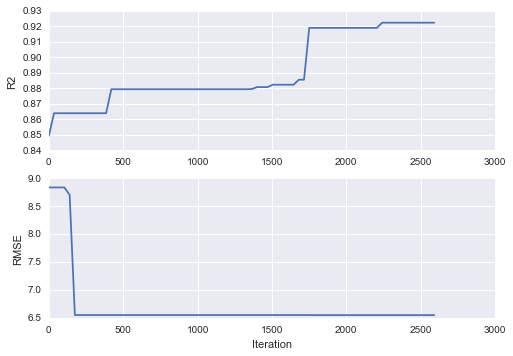

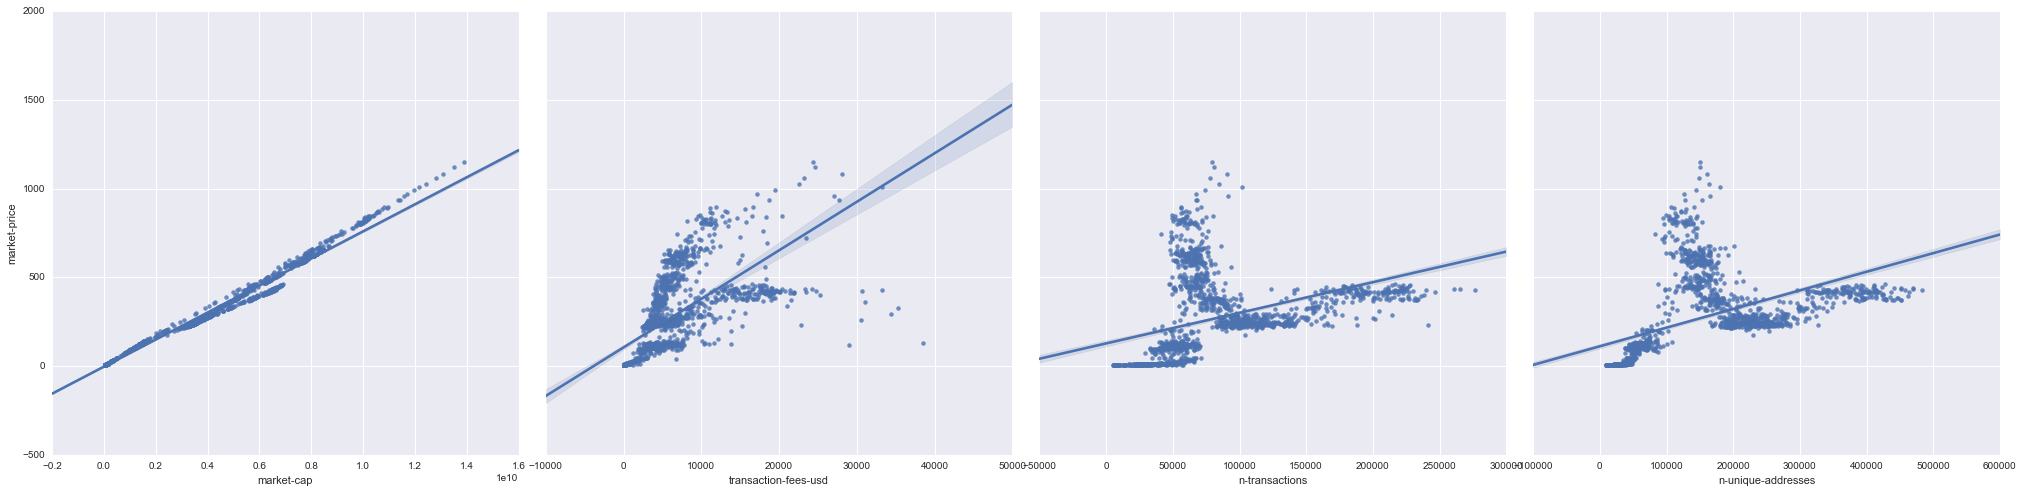

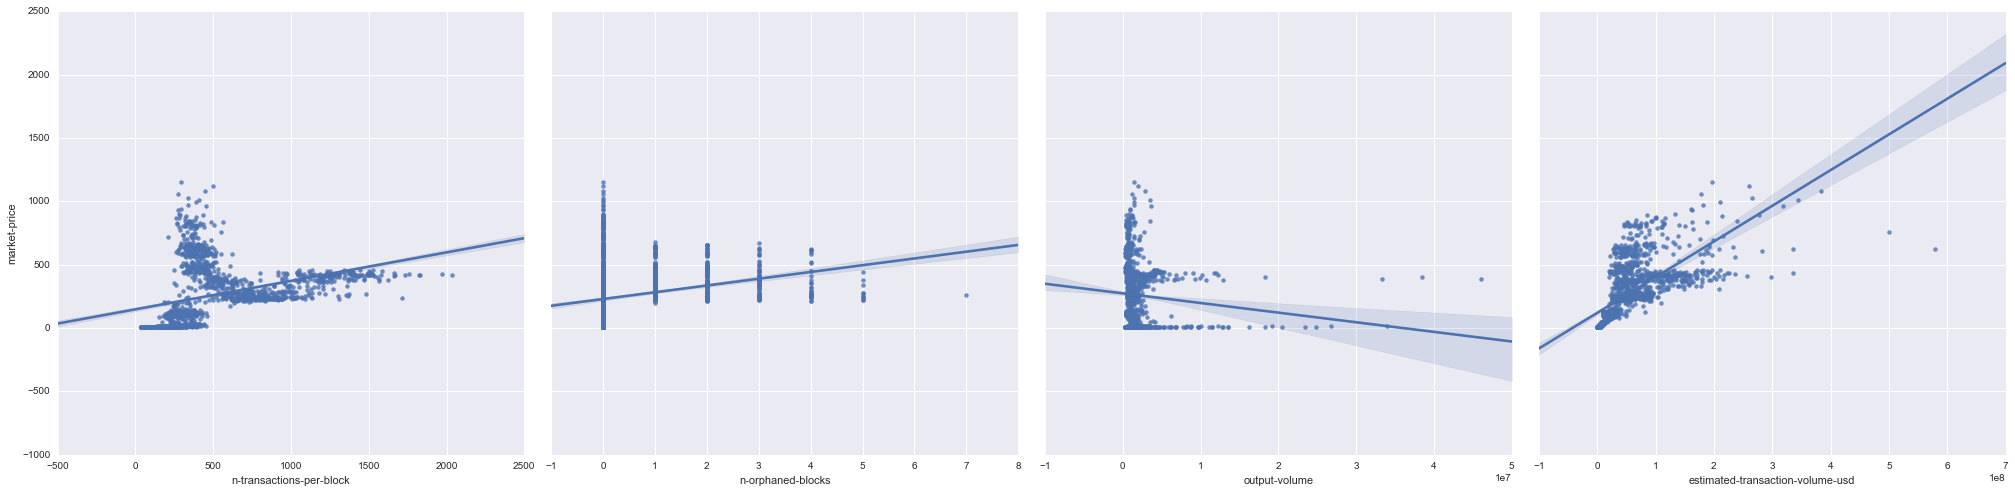

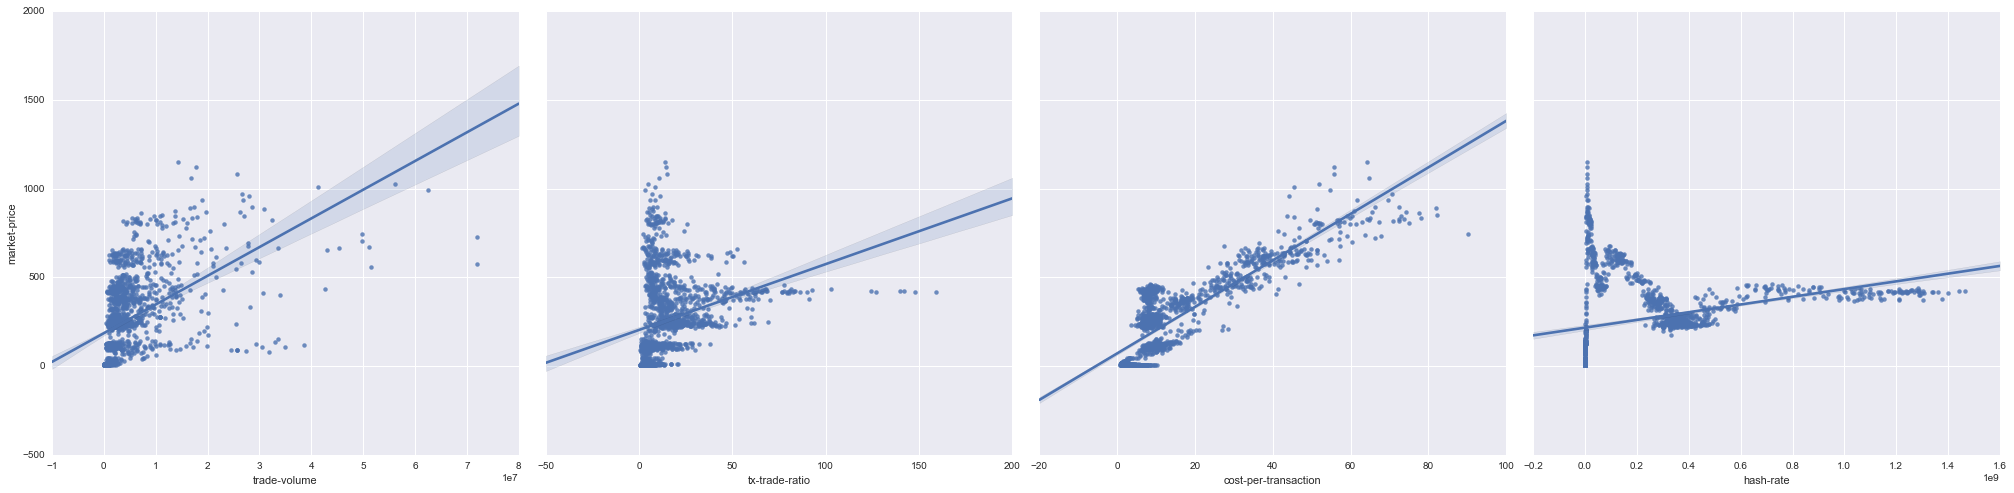

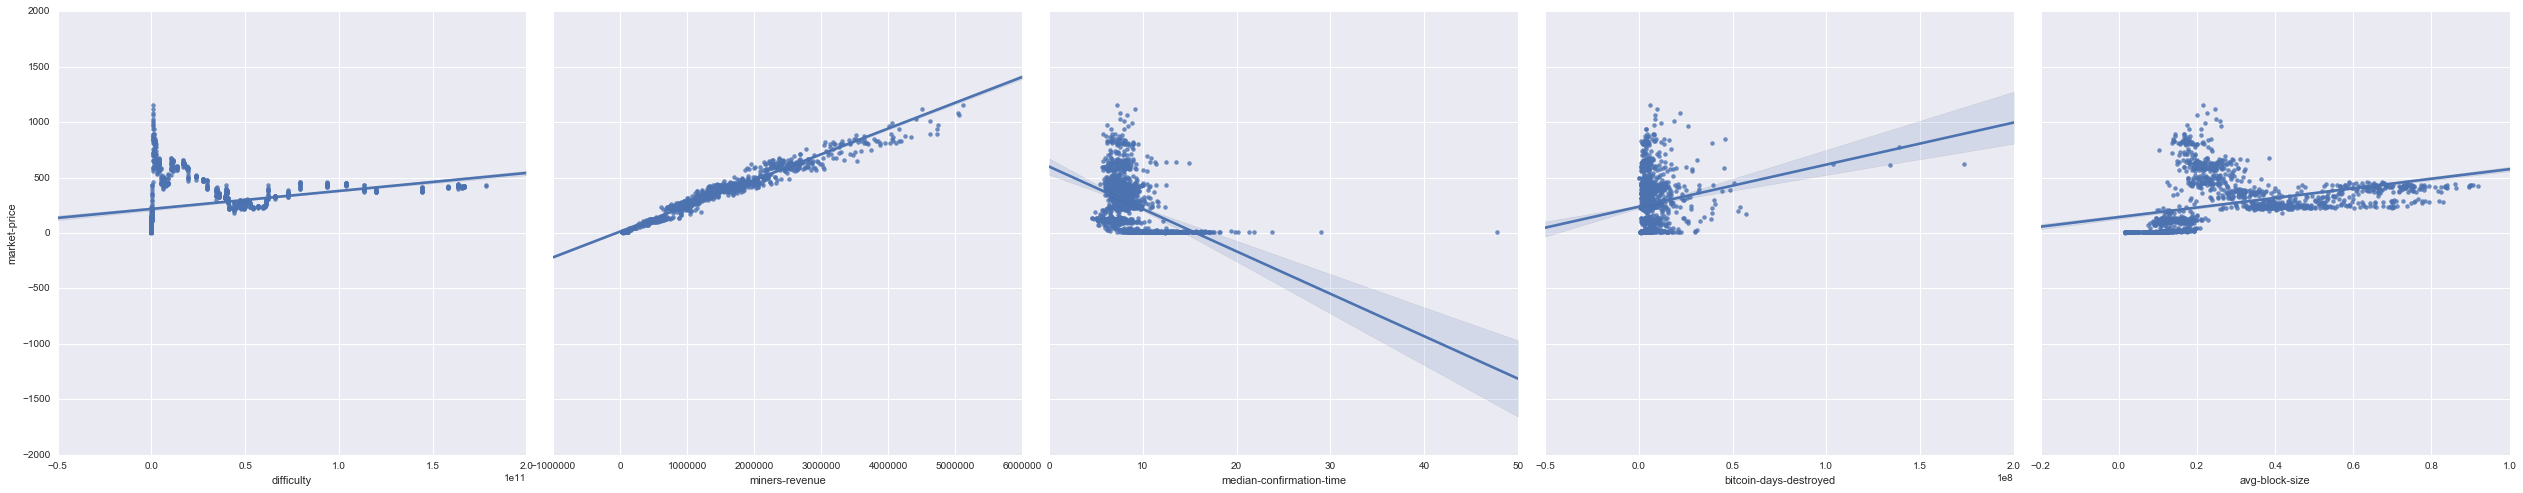

In [5]:
def feature_selection(date_from, date_to, gen_num, indiv_num):
    
    regr = linear_model.LinearRegression()
    
    prep_data(date_from, date_to)

    r2_results = nsga2_mlr(regr, regr.score, (1.0, -1.0), gen_num, indiv_num)
    x = list(range(0, indiv_num * gen_num, indiv_num))

    plt.subplot(2, 1, 1)
    plt.plot(x, r2_results[0])
    plt.ylabel('R2')

    print ('Features selected by NSGAII-MLR with R2: ', r2_results[1], '\n\n')

    RMSE = lambda x, y: np.sqrt(mse(y, regr.predict(x)))
    rmse_results = nsga2_mlr(regr, RMSE, (-1.0, -1.0), gen_num, indiv_num)

    plt.subplot(2, 1, 2)
    plt.plot(x, rmse_results[0])
    plt.ylabel('RMSE')
    plt.xlabel('Iteration')

    print ('Features selected by NSGAII-MLR with RMSE: ', rmse_results[1], '\n\n')
    
    data = pd.concat(FRAMES, axis = 1)
    sns.pairplot(data, x_vars = CHARTS[1:5], y_vars = CHARTS[0], size = 7, kind = 'reg')
    sns.pairplot(data, x_vars = CHARTS[5:9], y_vars = CHARTS[0], size = 7, kind = 'reg')
    sns.pairplot(data, x_vars = CHARTS[9:13], y_vars = CHARTS[0], size = 7, kind = 'reg')
    sns.pairplot(data, x_vars = CHARTS[13:], y_vars = CHARTS[0], size = 7, kind = 'reg')
    
widgets.interact(feature_selection, 
                 date_from = '1/4/2012', 
                 date_to = '4/13/2016', 
                 gen_num = 100, 
                 indiv_num = 35)

# Visualizing the actual and predicted prices 

RMSE: 15.627922820
Variance score: 0.959108034


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and wil

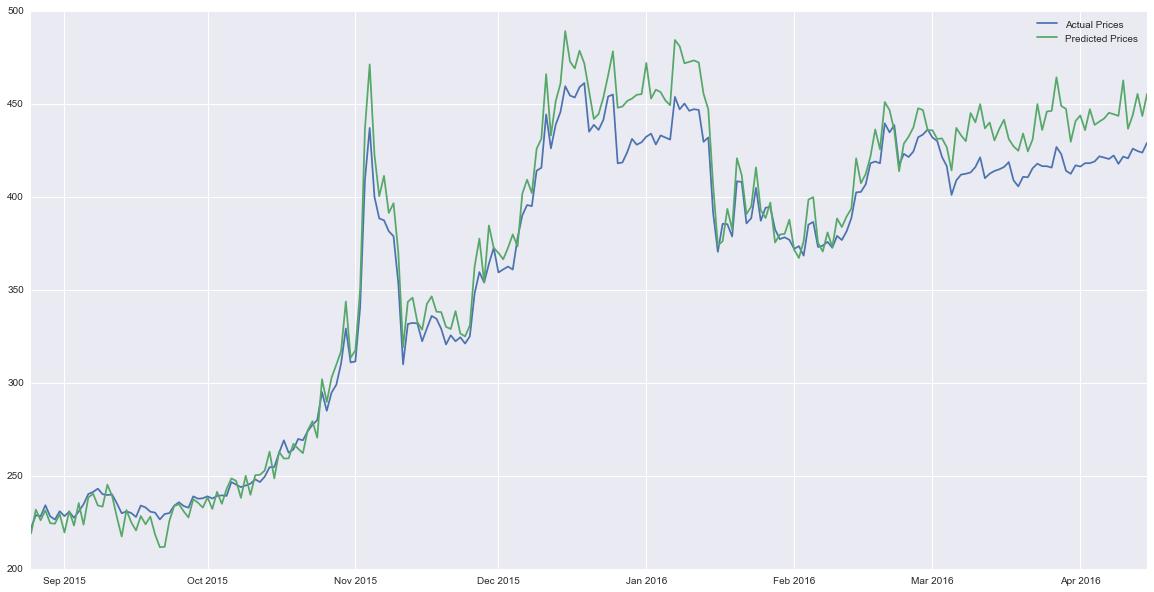

In [14]:
box = widgets.VBox()
cbs = map(lambda x: widgets.Checkbox(description = x, value = False), CHARTS[1:])
box.children=[i for i in cbs]
display(box)

button = widgets.Button(description="Evaluate Model", width = 5)

def evaluate(b):
    selected = []
    for i in range(len(CHARTS[1:])):
        selected.append(box.children[i].value)
        
    filtered_features = filter_features(selected)
    filtered_features = pd.concat(filtered_features, axis = 1)
    btc_features = pd.DataFrame(filtered_features.values).as_matrix()
    btc_target = pd.DataFrame(FRAMES[0]).as_matrix().flatten()

    btc_X_train = btc_features[:int(0.7*len(btc_features))]
    btc_X_validation = btc_features[int(0.7*len(btc_features)):int(0.85*len(btc_features))]

    btc_y_train = btc_target[:int(0.7*len(btc_target))]
    btc_y_validation = btc_target[int(0.7*len(btc_target)):int(0.85*len(btc_target))]

    # Create the learner

    regr = linear_model.LinearRegression()

    # Train the learner on the training data
    # and evaluate the performance by the test data

    regr.fit(btc_X_train, btc_y_train)
    btc_X_test = btc_features[int(0.85*len(btc_features)):]
    btc_y_test = btc_target[int(0.85*len(btc_target)):]
    scaler_act = preproc.StandardScaler().fit(btc_y_test)
    scaler_pred = preproc.StandardScaler().fit(regr.predict(btc_X_test))
    standardized_act = scaler_act.transform(btc_y_test)
    standardized_pred = scaler_pred.transform(regr.predict(btc_X_test))

    x = list(FRAMES[0][int(0.85*len(btc_features)):].index)

    plt.figure(figsize = (20,10))
    plt.plot(x, btc_y_test, label = 'Actual Prices')
    plt.plot(x, regr.predict(btc_X_test), label = 'Predicted Prices')
    plt.legend()

    print ('RMSE: %.9f' % (np.sqrt(mse(btc_y_test, regr.predict(btc_X_test)))))
    print ('Variance score: %.9f' % (regr.score(btc_X_test, btc_y_test)))
    
button.on_click(evaluate)
display(button)

# Price values

In [ ]:
compare_df = pd.DataFrame(data = list(zip(btc_y_test, regr.predict(btc_X_test))), 
                          index = features.index[int(0.7*len(btc_target)):], 
                          columns = ['actual', 'predicted'])
compare_df